#### Automatic Differentiation:
- Most functions have built-in gradients
- PyTorch uses the chain rule to compute gradients of function compositions
- use requires_grad=True to allow differentiation w.r.t. that variable
- use detach() to just getthe value of a variable

In [ ]:
# autograd example
import torch
import math
import matplotlib.pyplot as plt
x = torch.linspace(0., 2. * math.pi, steps=50, requires_grad=True)
print(x)
a=torch.sin(x)
print(a)
plt.plot(x.detach(),a.detach())

In [ ]:
# Each variable has grad_fn based on the last operation
b = 2 * a
print(b)
c = b + 1
print(c)
y = c.sum()
print(y)

In [ ]:
print('c:')
print(c.grad_fn)                 # the grad function
print(c.grad_fn.next_functions)  # the next grad functions based on the compositions


In [ ]:
# Here we see the chain rule in action
print('c:')
print(c.grad_fn)                 # the grad function
print(c.grad_fn.next_functions)  # the next grad functions based on the compositions
print(c.grad_fn.next_functions[0][0].next_functions)
print(c.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(c.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)
print('\nx:')
print(x.grad_fn)

In [ ]:
# Gradient of y w.r.t. x
y.backward()
print(x.grad)
plt.plot(x.detach(), b.detach())    # y=sum(2 sin(x_i)+1), dy/dx_i= 2 cos(xi)
plt.plot(x.detach(), x.grad.detach())

#### Optimization with Automatic Gradients
- We need an optimizer
- Can use SGD, Adam, LBFGS, etc
- LBFGS does not work well with some NNs because of ReLU activation

In [ ]:
## Generate some data
x=torch.randn(100,10)
beta=torch.randn(10,1)
y=x@beta+torch.randn(100,1)   # linear regression data

In [ ]:
# Analytic solution
def sqLoss(yhat,y):
    return torch.mean((yhat-y)**2)

xx=x.t()@x
xy=x.t()@y
w=torch.linalg.solve(xx,xy)
yhat=x@w
loss=sqLoss(yhat,y)
print(loss)

In [ ]:
import torch.optim as optim

w=torch.zeros((10,1),requires_grad=True)
optimizer = optim.SGD([w], lr=.1)  # used the Stochastic Gradient Descent optimizer
Niter=40
losses=[]
for i in range(Niter): 
    optimizer.zero_grad()    # zero the parameter gradients

    yhat=x@w
    loss = sqLoss(yhat,y)       # forward pass
    loss.backward()             # compute the gradients
    optimizer.step()            # optimize the loss fn

    # print statistics
    print('[%d] loss: %.3f' % (i+ 1, loss.item() ))
    losses.append(loss.item()) 
plt.plot(losses)              # show the loss function
plt.show()
plt.plot(beta,w.detach(),'.')

#### Neural Networks
- should extend the torch.nn.Module
- should have a forward function
- many types of layers
- each layer usually followed by an activation function

#### Neural Network Layers
- fully connected layer (Linear): y=xW+w0
- 1D, 2D, 3D convolutional layer:  y=x * W+w0 (where "*" means convolution)
- pooling layers, e.g. max pooling

#### NN Activation Functions
- ReLU (Rectified Linear Unit) activation: y=max(x,0)
- sigmoid activation: y=1/(1+exp(-x))
- tanh activation: y=tanh(x)
- many others

#### NN Regression Loss Functions
- MSE loss: y=sum((y-yhat)**2) 
- L1 loss: y=sum(abs(y-yhat))
- many others (e.g. Huber L1 loss)
- sum can be replaced by mean

#### NN Classification Loss Functions
- cross-entropy loss
- negative log likelihood (NLL) loss
- KL divergence loss
- many others

In [ ]:
# Generate some nonlinear regression data
n=10000
x=torch.randn(2*n,10) # generate train and test data
beta=torch.randn(10,1)
y=torch.sin(x@beta)+torch.randn(2*n,1)*0.3   # non-linear regression data
xt=x[n:,:]  # split the test data from the train
yt=y[n:,:]
x=x[:n,:]
y=y[:n,:]

In [ ]:
# define a NN
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self,d):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(d, 100)  
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)  # 1 output neurons for regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net=Net(10)
yhat=net(x)

In [ ]:
# train the NN
net=Net(10)
#optimizer = optim.SGD(net.parameters(), lr=.1)  # use the Stochastic Gradient Descent optimizer
optimizer = optim.Adam(net.parameters(), lr=.01)  # use the Adam optimizer
Niter=300
losses=[]
lossest=[]
lossfn = nn.MSELoss()
for i in range(Niter): 
    optimizer.zero_grad()    # zero the parameter gradients

    yhat=net(x)
    loss = lossfn(yhat,y)       # forward pass
    loss.backward()             # compute the gradients
    optimizer.step()            # optimize the loss fn

    # print statistics
    with torch.no_grad(): # we don't need gradients for test data
        yhatt=net(xt)
        lost=lossfn(yhatt,yt)
    print('[%d] loss: %.3f, %.3f' % (i+ 1, loss.item(), lost.item() ))
    losses.append(loss.item()) 
    lossest.append(lost.item()) 
plt.plot(losses)              # show the loss function
plt.plot(lossest)              # show the loss function on the test set
plt.show()
plt.plot(y,yhat.detach(),'.')
plt.plot(yt,yhatt,'.')

#### Using Minibatches
- If data is large, can use batches of data to generate noisy gradients and optimize faster
- We need to define a dataset and a data loader
#### Datasets
- classes that encapsulate the data
- allow to access any data point
- can transform the data on the fly (for data augmentation)
#### Data Loaders
- iterate over the data
- shuffle the data and generate batches

In [ ]:
loss.item()

In [ ]:
# generate a dataset and a data loader
from torch.utils.data import Dataset, DataLoader

dataset=torch.utils.data.TensorDataset(x,y) # dataset made of tensor data
loader=torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True)

# train the NN
net=Net(10)
#optimizer = optim.SGD(net.parameters(), lr=.1)  # use the Stochastic Gradient Descent optimizer
optimizer = optim.Adam(net.parameters(), lr=.01)  # use the Adam optimizer
Niter=20
losses=[]
lossest=[]
lossfn = nn.MSELoss(reduction='mean')
for ep in range(Niter): 
    sumloss=0
    for data in loader:
        xi,yi=data
        optimizer.zero_grad()    # zero the parameter gradients

        yhat=net(xi)
        loss = lossfn(yhat,yi)       # forward pass
        loss.backward()             # compute the gradients
        optimizer.step()            # optimize the loss fn
        sumloss+=loss.item()*xi.shape[0]

    # print statistics
    with torch.no_grad(): # we don't need gradients for test data
        yhatt=net(xt)
        lost=lossfn(yhatt,yt)
    print('[%d] loss: %.3f, %.3f' % (ep+ 1, sumloss/n, lost.item()))
    losses.append(sumloss/n) 
    lossest.append(lost.item()) 
plt.plot(losses)              # show the loss function
plt.plot(lossest)              # show the loss function on the test set
plt.show()
plt.plot(yi,yhat.detach(),'.')
plt.plot(yt,yhatt,'.')

In [ ]:
import numpy as np
X = np.loadtxt("abalone.csv", delimiter=',')
Y=X[:,7]
X=X[:,0:7]
print(X.shape,Y.shape)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
def train(net,x,y):
    dataset=torch.utils.data.TensorDataset(x,y) # dataset made of tensor data
    loader=torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True)
    #optimizer = optim.SGD(net.parameters(), lr=.1)  # use the Stochastic Gradient Descent optimizer
    optimizer = optim.Adam(net.parameters(), lr=.01)  # use the Adam optimizer
    Niter=30
    lossfn = nn.MSELoss()
    for i in range(Niter): 
        sumloss=0
        for data in loader:
            xi,yi=data
            optimizer.zero_grad()    # zero the parameter gradients

            yhat=net(xi).squeeze()
            #print(yhat.shape,yi.shape)
            loss = lossfn(yhat,yi)       # forward pass
            loss.backward()             # compute the gradients
            optimizer.step()            # optimize the loss fn
            sumloss+=loss.item()

r2=[]
r2t=[]
for r in range(10):
    x,xt,y,yt = train_test_split(X, Y, test_size=0.1, random_state=r)
    x=torch.tensor(x).float()
    y=torch.tensor(y).float()
    xt=torch.tensor(xt).float()
    yt=torch.tensor(yt).float()
    mx=torch.mean(x,0)
    sx=torch.std(x,0)
    x=(x-mx)/sx
    xt=(xt-mx)/sx
    my=torch.mean(y)
    y-=my
    yt-=my
    net=Net(7)
    train(net,x,y)
    with torch.no_grad():
        py=net(x)
        pyt=net(xt)
    r2i=r2_score(y, py)
    r2ti=r2_score(yt, pyt)
    print(r,r2i,r2ti)
    r2.append(r2i)
    r2t.append(r2ti)
print("train R2=%.3f, test R2=%.3f"%(np.mean(r2),np.mean(r2t)))

#### Transforms
- allow to transform the images on the fly
- e.g. data normalization or random cropping the images

In [99]:
# CIFAR-10 example
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#transform = transforms.Compose(
#    [transforms.RandomCrop(28),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='d:/datasets/CIFAR10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='d:/datasets/CIFAR10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4096,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [100]:
# move data to GPU
def getdata(loader):
    x=torch.empty(0,3,32,32)
    y=torch.empty(0)
    for data in loader:
        xi,yi=data
        x=torch.cat((x,xi),axis=0)
        y=torch.cat((y,yi))
    return x,y

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
x,y=getdata(trainloader)
xt,yt=getdata(testloader)
x,y=x.to(device),y.to(device)
xt,yt=xt.to(device),yt.to(device)
print(x.shape,y.shape,xt.shape,yt.shape)
traindata=torch.utils.data.TensorDataset(x,y) # dataset made of tensor data
trainloader=torch.utils.data.DataLoader(traindata,batch_size=128,shuffle=True)
testdata=torch.utils.data.TensorDataset(xt,yt) # dataset made of tensor data
testloader=torch.utils.data.DataLoader(testdata,batch_size=4096,shuffle=False)

cuda:0
torch.Size([50000, 3, 32, 32]) torch.Size([50000]) torch.Size([10000, 3, 32, 32]) torch.Size([10000])


In [ ]:
# viewing some images
for i in range(1000):
    im,l=trainset[i]
    if l==9:
        break
print(i,torch.min(im), torch.max(im),l)
plt.imshow(im.permute(1,2,0)/2+0.5)

In [96]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x=F.relu(self.conv1(x))
        #print(1,x.shape)
        x = self.pool(x)
        #print(2,x.shape)       
        x=F.relu(self.conv2(x))
        #print(3,x.shape)
        x = self.pool(x)
        #print(4,x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(5,x.shape)
        x = F.relu(self.fc1(x))
        #print(6,x.shape)
        x = F.relu(self.fc2(x))
        #print(7,x.shape)
        x = self.fc3(x)
        #print(8,x.shape)
        return x

net = Net()
for im,l in trainloader:
    break
py=net(im)

[1] loss=1.685, errs: 0.534, 0.535 t= 2.1
[2] loss=1.468, errs: 0.517, 0.524 t= 4.0
[3] loss=1.408, errs: 0.487, 0.501 t= 5.8
[4] loss=1.367, errs: 0.468, 0.484 t= 7.5
[5] loss=1.328, errs: 0.447, 0.476 t= 9.3
[6] loss=1.301, errs: 0.436, 0.468 t= 11.3
[7] loss=1.284, errs: 0.466, 0.496 t= 13.0
[8] loss=1.266, errs: 0.444, 0.475 t= 14.8
[9] loss=1.235, errs: 0.411, 0.450 t= 16.6
[10] loss=1.223, errs: 0.416, 0.451 t= 18.4
[11] loss=1.201, errs: 0.403, 0.448 t= 20.1
[12] loss=1.185, errs: 0.415, 0.463 t= 21.9
[13] loss=1.167, errs: 0.439, 0.474 t= 23.7
[14] loss=1.162, errs: 0.376, 0.433 t= 25.6
[15] loss=1.153, errs: 0.393, 0.449 t= 27.4
[16] loss=1.148, errs: 0.390, 0.439 t= 29.2
[17] loss=1.136, errs: 0.382, 0.435 t= 30.9
[18] loss=1.127, errs: 0.378, 0.442 t= 32.6
[19] loss=1.119, errs: 0.374, 0.442 t= 34.5
[20] loss=1.119, errs: 0.431, 0.477 t= 36.2
[21] loss=1.106, errs: 0.376, 0.441 t= 37.9
[22] loss=1.113, errs: 0.356, 0.429 t= 39.8
[23] loss=1.095, errs: 0.356, 0.434 t= 41.8
[2

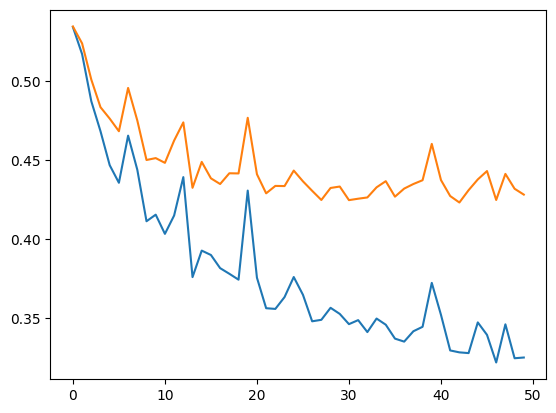

In [87]:
from time import time
import matplotlib.pyplot as plt
def missclferr(net,loader):
    sumerr=0
    n=0
    with torch.no_grad(): # we don't need gradients for test data
        for xi,yi in loader:
            xi,yi=xi.to(device),yi.to(device)
            out=net(xi)
            py=torch.argmax(out,1)
            ni=xi.shape[0]
            sumerr+=torch.sum(py!=yi).item()
            n+=ni
    return sumerr/n
    
# train the NN
net=Net()
net=net.to(device)
optimizer = optim.SGD(net.parameters(), lr=.1)  # use the Stochastic Gradient Descent optimizer
#optimizer = optim.Adam(net.parameters(), lr=.01)  # use the Adam optimizer
Niter=50
errs=[]
errst=[]
lossfn = nn.CrossEntropyLoss()
t0=time()
for ep in range(Niter): 
    sumloss=0
    n=0
    for data in trainloader:
        xi,yi=data
        xi,yi=xi.to(device),yi.to(device)
        optimizer.zero_grad()    # zero the parameter gradients

        out=net(xi)
        loss = lossfn(out,yi.long())       # forward pass
        loss.backward()             # compute the gradients
        optimizer.step()            # optimize the loss fn
        ni=xi.shape[0]
        sumloss+=loss.item()*ni
        n+=ni
    # print statistics
    err=missclferr(net,trainloader)
    errt=missclferr(net,testloader)
    print('[%d] loss=%.3f, errs: %.3f, %.3f t= %1.1f' % (ep+ 1, sumloss/n, err, errt, time()-t0))
    errs.append(err) 
    errst.append(errt) 
plt.plot(errs)              # show the loss function
plt.plot(errst)              # show the loss function on the test set
plt.show()

#### Schedulers
- the learning rate (LR) must decrease during optimization
- schedulers control how to decrease the LR
- ExponentialLR decreases it by gamma each epoch
- StepLR decreases it by gamma every step epochs


[1] loss=2.088, errs: 0.666, 0.651 t= 1.9 lr=0.100
[2] loss=1.701, errs: 0.580, 0.566 t= 3.5 lr=0.100
[3] loss=1.542, errs: 0.542, 0.527 t= 5.3 lr=0.100
[4] loss=1.454, errs: 0.523, 0.519 t= 6.9 lr=0.100
[5] loss=1.388, errs: 0.496, 0.489 t= 8.5 lr=0.100
[6] loss=1.341, errs: 0.463, 0.463 t= 10.2 lr=0.100
[7] loss=1.293, errs: 0.462, 0.454 t= 11.9 lr=0.100
[8] loss=1.264, errs: 0.441, 0.438 t= 13.5 lr=0.100
[9] loss=1.232, errs: 0.485, 0.480 t= 15.2 lr=0.100
[10] loss=1.204, errs: 0.416, 0.414 t= 17.0 lr=0.100
[11] loss=1.184, errs: 0.425, 0.423 t= 18.7 lr=0.100
[12] loss=1.161, errs: 0.444, 0.432 t= 20.3 lr=0.100
[13] loss=1.142, errs: 0.414, 0.418 t= 22.1 lr=0.100
[14] loss=1.128, errs: 0.425, 0.426 t= 23.7 lr=0.100
[15] loss=1.111, errs: 0.378, 0.378 t= 25.4 lr=0.100
[16] loss=1.091, errs: 0.379, 0.375 t= 27.1 lr=0.100
[17] loss=1.079, errs: 0.382, 0.387 t= 28.9 lr=0.100
[18] loss=1.062, errs: 0.386, 0.394 t= 30.5 lr=0.100
[19] loss=1.056, errs: 0.359, 0.368 t= 32.2 lr=0.100
[20] lo

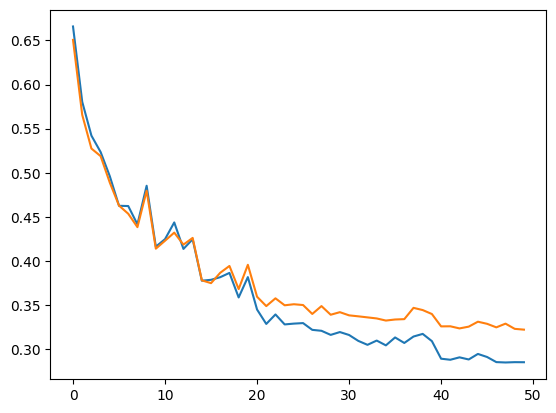

In [104]:
from time import time
# Scheduler examples
# train the NN
from torch.optim.lr_scheduler import ExponentialLR, StepLR, MultiStepLR

def missclferr(net,tr,loader):
    sumerr=0
    n=0
    with torch.no_grad(): # we don't need gradients for test data
        for xi,yi in loader:
            xi,yi=xi.to(device),yi.to(device)
            xi=tr(xi)
            out=net(xi)
            py=torch.argmax(out,1)
            ni=xi.shape[0]
            sumerr+=torch.sum(py!=yi).item()
            n+=ni
    return sumerr/n


net=Net()
net=net.to(device)
optimizer = optim.SGD(net.parameters(), lr=.1)  # use the Stochastic Gradient Descent optimizer
#optimizer = optim.Adam(net.parameters(), lr=.05)  # use the Adam optimizer
#scheduler = ExponentialLR(optimizer, gamma=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
#scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
tr=transforms.RandomCrop(28)
te=transforms.CenterCrop(28)
Niter=50
errs=[]
errst=[]
lossfn = nn.CrossEntropyLoss(reduction='mean')
t0=time()
for ep in range(Niter): 
    sumloss=0
    n=0
    for data in trainloader:
        xi,yi=data
        xi,yi=xi.to(device),yi.to(device)
        optimizer.zero_grad()    # zero the parameter gradients
        xi=tr(xi)
        yhat=net(xi)
        loss = lossfn(yhat,yi.long())       # forward pass
        loss.backward()             # compute the gradients
        optimizer.step()            # optimize the loss fn
        ni=xi.shape[0]
        sumloss+=loss.item()*ni
        n+=ni
    # print statistics
    scheduler.step()
    err=missclferr(net,tr,trainloader)
    errt=missclferr(net,te,testloader)
    print('[%d] loss=%.3f, errs: %.3f, %.3f t= %1.1f lr=%.3f' % (ep+ 1, sumloss/n, err, errt, time()-t0, scheduler.get_last_lr()[-1]))
    errs.append(err) 
    errst.append(errt) 
plt.plot(errs)              # show the loss function
plt.plot(errst)              # show the loss function on the test set
plt.show()

In [ ]:
# data augmentation
transform = transforms.Compose(
    [transforms.RandomCrop(28),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
